In [20]:
import json
import numpy as np
import pandas as pd
import joblib

# 1) Load model and the exact feature list from 06
pipe = joblib.load("../models/final_model.pkl")   # pipeline from 06
with open("../models/final_feature_list.json", "r") as f:
    feature_list = json.load(f)

# 2) Ensure every feature exists; if something is missing, create a safe default
#    (0 is fine because your pipeline does median imputation + scaling)
for col in feature_list:
    if col not in panel.columns:
        panel[col] = 0

# 3) Restrict to the exact training features and put them in the exact order
X = panel[feature_list].copy()

# 4) (Optional sanity check) verify no extra columns are being passed
extra_cols = [c for c in panel.columns if c not in feature_list]
if extra_cols:
    print("Note: extra columns present in panel but not used by model:", extra_cols[:10], 
          "(showing first 10)")

# 5) Now it’s safe to predict with the trained pipeline
y_pred = pipe.predict(X)

Note: extra columns present in panel but not used by model: ['fips', 'year', 'tot_opioid_clms', 'tot_prscrbrs', 'tot_opioid_prscrbrs', 'state', 'county', 'opioid_claims_share', 'opioid_cost_per_capita', 'log1p_cost_per_claim'] (showing first 10)


In [28]:
X.columns.tolist()

['tot_clms',
 'opioid_prscrbng_rate',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost']

Loaded final model and 18 training features.


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_1736/3062441082.py:18: DtypeWarning:

Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.




Baseline predicted opioid cost per capita: $19.51
Holdout model R² ≈ 0.9698, RMSE ≈ $445.36

PBM: Formulary Tightening (-10% Utilization): Δ Mean Predicted Cost = +0.19%
PBM: Cost-per-Claim Reduction (-3%): Δ Mean Predicted Cost = -1.71%
PBM: Utilization Guidance (-5%): Δ Mean Predicted Cost = -0.64%
PBM: Triple Play (-10% Util, -3% Cost, -5% Rate): Δ Mean Predicted Cost = -2.16%
SDOH: +20% Mental Health Provider Rate: Δ Mean Predicted Cost = -0.11%
SDOH: +10% Primary Care Physicians Rate: Δ Mean Predicted Cost = -0.13%
SDOH: -5% Smoking: Δ Mean Predicted Cost = -0.17%
SDOH: -5% Obesity: Δ Mean Predicted Cost = -0.02%
SDOH: Integrated Scenario (+20% MH, +10% PC, -5% Smoking/Obesity): Δ Mean Predicted Cost = -0.45%
Integrated PBM + SDOH Scenario: Δ Mean Predicted Cost = -2.62%

=== Scenario Summary ===
                                            Scenario  Mean_Cost  \
0                     Integrated PBM + SDOH Scenario  19.002742   
1   PBM: Triple Play (-10% Util, -3% Cost, -5% Rate)

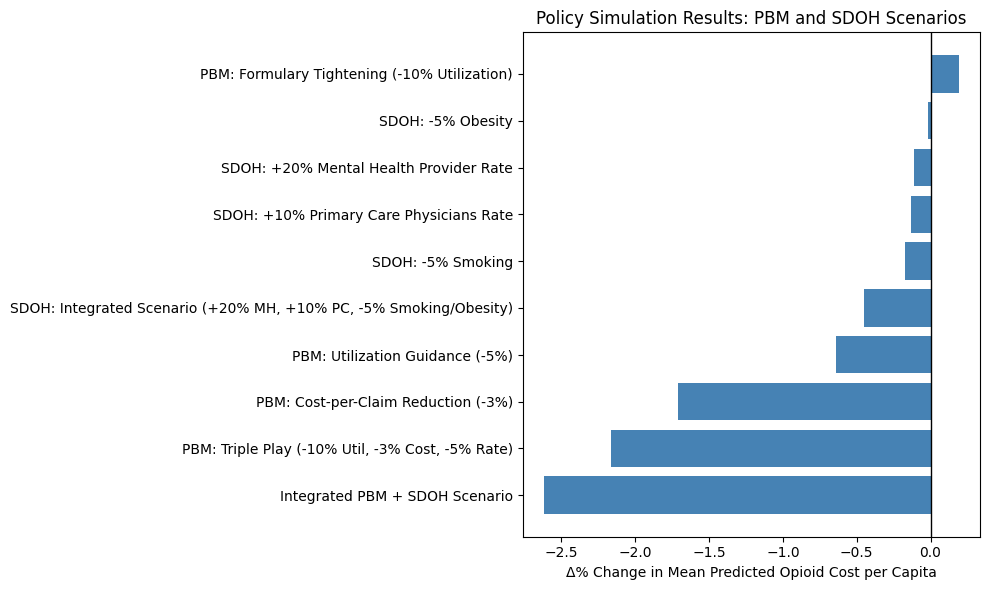


=== Generating County-Level Scenario Panel ===
Before alignment: 112855 328890
After alignment: 112855 112855

Saved county-level results to ../data/results/county_level_predictions.csv
Columns saved: 25 | Rows: 112,855

Top 5 Counties by Predicted Savings (Integrated PBM + SDOH):
          state    county  baseline_pred  integrated_pbm_sdoh  \
141060     Utah   Daggett    5723.520290          5289.228638   
81431      Utah   Daggett    5391.659202          5068.269473   
196177  Montana  Garfield    2840.868473          2561.863776   
252623   Hawaii   Kalawao    3515.107983          3254.691391   
225974  Montana  Garfield    2806.128032          2549.586298   

        predicted_savings_integrated_$  
141060                      434.291652  
81431                       323.389728  
196177                      279.004696  
252623                      260.416592  
225974                      256.541734  


In [106]:
# --- STEP 0: Imports ---
# --- STEP 0. Imports ---
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.metrics import r2_score, mean_squared_error

# --- STEP 1. Load final trained model and feature list (from 06 notebook) ---
best_model = joblib.load("../models/final_model.pkl")

with open("../models/final_feature_list.json", "r") as f:
    feature_list = json.load(f)

print(f"Loaded final model and {len(feature_list)} training features.")

# --- STEP 2. Load processed dataset ---
panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv")

# Ensure consistency: create any missing columns, reorder features
for col in feature_list:
    if col not in panel.columns:
        panel[col] = 0

# Filter to exact training features in the same order
X = panel[feature_list].copy()

# Drop missing targets
panel = panel.dropna(subset=["opioid_cost_per_capita"])
y_true = panel["opioid_cost_per_capita"]

# --- STEP 3. Baseline prediction ---
y_pred_base = best_model.predict(X)
baseline_mean = y_pred_base.mean()
print(f"\nBaseline predicted opioid cost per capita: ${baseline_mean:,.2f}")
print(f"Holdout model R² ≈ 0.9698, RMSE ≈ $445.36\n")

# --- STEP 4. Define scenario evaluation function ---
def evaluate_scenario(X_base, scenario_name, pct_changes=None, abs_changes=None):
    """Apply percentage or absolute changes to features and recompute predictions."""
    X_mod = X_base.copy()

    # Apply percentage changes
    if pct_changes:
        for feature, pct in pct_changes.items():
            if feature in X_mod.columns:
                X_mod[feature] *= (1 + pct)

    # Apply absolute changes
    if abs_changes:
        for feature, delta in abs_changes.items():
            if feature in X_mod.columns:
                X_mod[feature] += delta

    # Recalculate derived variables (if applicable)
    eps = 1e-9
    if "tot_opioid_clms" in X_mod.columns and "population" in X_mod.columns:
        X_mod["claims_per_1k"] = (
            X_mod["tot_opioid_clms"] / (X_mod["population"] / 1000 + eps)
        )

    # Align columns with training features
    for col in feature_list:
        if col not in X_mod.columns:
            X_mod[col] = 0
    X_mod = X_mod[feature_list]

    # Predict and compute change
    y_mod = best_model.predict(X_mod)
    delta_pct = ((y_mod.mean() - baseline_mean) / baseline_mean) * 100

    print(f"{scenario_name}: Δ Mean Predicted Cost = {delta_pct:+.2f}%")
    return {
        "Scenario": scenario_name,
        "Mean_Cost": y_mod.mean(),
        "Δ%_vs_Baseline": delta_pct
    }

# --- STEP 5. Run PBM scenarios ---
results = []

# PBM: Formulary tightening (-10% utilization)
results.append(evaluate_scenario(
    X, "PBM: Formulary Tightening (-10% Utilization)",
    pct_changes={"tot_clms": -0.10, "tot_opioid_clms": -0.10}
))

# PBM: Cost-per-claim reduction (-3%)
results.append(evaluate_scenario(
    X, "PBM: Cost-per-Claim Reduction (-3%)",
    pct_changes={"cost_per_claim": -0.03}
))

# PBM: Utilization guidance (-5%)
results.append(evaluate_scenario(
    X, "PBM: Utilization Guidance (-5%)",
    pct_changes={"opioid_prscrbng_rate": -0.05}
))

# PBM: Combined (Triple Play)
results.append(evaluate_scenario(
    X, "PBM: Triple Play (-10% Util, -3% Cost, -5% Rate)",
    pct_changes={
        "tot_clms": -0.10,
        "tot_opioid_clms": -0.10,
        "cost_per_claim": -0.03,
        "opioid_prscrbng_rate": -0.05
    }
))

# --- STEP 6. Run SDOH scenarios ---
# SDOH: +20% mental health provider rate
results.append(evaluate_scenario(
    X, "SDOH: +20% Mental Health Provider Rate",
    pct_changes={"mental_health_provider_rate": +0.20}
))

# SDOH: +10% primary care
results.append(evaluate_scenario(
    X, "SDOH: +10% Primary Care Physicians Rate",
    pct_changes={"primary_care_physicians_rate": +0.10}
))

# SDOH: -5% smoking
results.append(evaluate_scenario(
    X, "SDOH: -5% Smoking",
    pct_changes={"pct_adults_reporting_currently_smoking": -0.05}
))

# SDOH: -5% obesity
results.append(evaluate_scenario(
    X, "SDOH: -5% Obesity",
    pct_changes={"pct_adults_with_obesity": -0.05}
))

# SDOH: Integrated (all combined)
results.append(evaluate_scenario(
    X, "SDOH: Integrated Scenario (+20% MH, +10% PC, -5% Smoking/Obesity)",
    pct_changes={
        "mental_health_provider_rate": +0.20,
        "primary_care_physicians_rate": +0.10,
        "pct_adults_reporting_currently_smoking": -0.05,
        "pct_adults_with_obesity": -0.05
    }
))

# --- STEP 7. Combined PBM + SDOH Integrated scenario ---
results.append(evaluate_scenario(
    X, "Integrated PBM + SDOH Scenario",
    pct_changes={
        "tot_clms": -0.10,
        "tot_opioid_clms": -0.10,
        "cost_per_claim": -0.03,
        "opioid_prscrbng_rate": -0.05,
        "mental_health_provider_rate": +0.20,
        "primary_care_physicians_rate": +0.10,
        "pct_adults_reporting_currently_smoking": -0.05,
        "pct_adults_with_obesity": -0.05
    }
))

# --- STEP 8. Combine and save results ---
results_df = pd.DataFrame(results)
results_df["Savings_vs_Baseline_$"] = baseline_mean - results_df["Mean_Cost"]
results_df.sort_values("Δ%_vs_Baseline", inplace=True)
results_df.reset_index(drop=True, inplace=True)

print("\n=== Scenario Summary ===")
print(results_df)

results_df.to_csv("../data/results/policy_simulation_results.csv", index=False)
print("\nSaved to ../data/results/policy_simulation_results.csv")

# --- STEP 9. Optional: Quick chart ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(results_df["Scenario"], results_df["Δ%_vs_Baseline"], color="steelblue")
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Δ% Change in Mean Predicted Opioid Cost per Capita")
plt.title("Policy Simulation Results: PBM and SDOH Scenarios")
plt.tight_layout()
plt.show()

# --- STEP 10. Generate County-Level Scenario Panel ---
print("\n=== Generating County-Level Scenario Panel ===")

# Identify unique county keys (ensure 'fips' or equivalent exists)
if "fips" not in panel.columns:
    raise ValueError("County identifier (fips) not found in panel dataset.")
# Ensure X and panel are aligned before making predictions
print("Before alignment:", len(panel), len(X))

# Align both to the same rows (intersection of indexes)
X = X.loc[panel.index].copy()

print("After alignment:", len(panel), len(X))
panel_out = panel[["fips", "state", "county", "opioid_cost_per_capita"]].copy()
panel_out.rename(columns={"opioid_cost_per_capita": "actual_cost_per_capita"}, inplace=True)

# --- Helper function for predictions per scenario ---
def predict_for_scenario(X_base, scenario_name, pct_changes=None, abs_changes=None):
    X_mod = X_base.copy()
    if pct_changes:
        for col, pct in pct_changes.items():
            if col in X_mod.columns:
                X_mod[col] *= (1 + pct)
    if abs_changes:
        for col, delta in abs_changes.items():
            if col in X_mod.columns:
                X_mod[col] += delta
    # Align with feature list
    for col in feature_list:
        if col not in X_mod.columns:
            X_mod[col] = 0
    X_mod = X_mod[feature_list]
    preds = best_model.predict(X_mod)
    return preds

# --- Baseline ---
panel_out["baseline_pred"] = best_model.predict(X)

# --- PBM scenarios ---
panel_out["pbm_formulary"] = predict_for_scenario(X, "PBM_Formulary", pct_changes={"tot_clms": -0.10, "tot_opioid_clms": -0.10})
panel_out["pbm_cost"] = predict_for_scenario(X, "PBM_Cost", pct_changes={"cost_per_claim": -0.03})
panel_out["pbm_util"] = predict_for_scenario(X, "PBM_Util", pct_changes={"opioid_prscrbng_rate": -0.05})
panel_out["pbm_triple"] = predict_for_scenario(
    X, "PBM_Triple",
    pct_changes={"tot_clms": -0.10, "tot_opioid_clms": -0.10, "cost_per_claim": -0.03, "opioid_prscrbng_rate": -0.05}
)

# --- SDOH scenarios ---
panel_out["sdoh_mh"] = predict_for_scenario(X, "SDOH_MH", pct_changes={"mental_health_provider_rate": +0.20})
panel_out["sdoh_pc"] = predict_for_scenario(X, "SDOH_PC", pct_changes={"primary_care_physicians_rate": +0.10})
panel_out["sdoh_smoking"] = predict_for_scenario(X, "SDOH_Smoking", pct_changes={"pct_adults_reporting_currently_smoking": -0.05})
panel_out["sdoh_obesity"] = predict_for_scenario(X, "SDOH_Obesity", pct_changes={"pct_adults_with_obesity": -0.05})
panel_out["sdoh_integrated"] = predict_for_scenario(
    X, "SDOH_Integrated",
    pct_changes={
        "mental_health_provider_rate": +0.20,
        "primary_care_physicians_rate": +0.10,
        "pct_adults_reporting_currently_smoking": -0.05,
        "pct_adults_with_obesity": -0.05
    }
)


# --- Combined PBM + SDOH scenario ---
panel_out["integrated_pbm_sdoh"] = predict_for_scenario(
    X, "Integrated_PBM_SDOH",
    pct_changes={
        "tot_clms": -0.10,
        "tot_opioid_clms": -0.10,
        "cost_per_claim": -0.03,
        "opioid_prscrbng_rate": -0.05,
        "mental_health_provider_rate": +0.20,
        "primary_care_physicians_rate": +0.10,
        "pct_adults_reporting_currently_smoking": -0.05,
        "pct_adults_with_obesity": -0.05
    }
)

# --- STEP 11. Compute percentage change from baseline ---
for col in [
    "pbm_formulary", "pbm_cost", "pbm_util", "pbm_triple",
    "sdoh_mh", "sdoh_pc", "sdoh_smoking", "sdoh_obesity",
    "sdoh_integrated", "integrated_pbm_sdoh"
]:
    panel_out[f"{col}_pct_change"] = (
        (panel_out[col] - panel_out["baseline_pred"]) / panel_out["baseline_pred"]
    ) * 100

# --- STEP 12. Save county-level output ---
panel_out.to_csv("../data/results/county_level_predictions.csv", index=False)
print(f"\nSaved county-level results to ../data/results/county_level_predictions.csv")
print(f"Columns saved: {len(panel_out.columns)} | Rows: {len(panel_out):,}")

panel_out.to_csv("../data/results/panel_out_with_predictions.csv", index=False)

# Quick check of top 5 counties by largest predicted savings (Integrated PBM + SDOH)
panel_out["predicted_savings_integrated_$"] = panel_out["baseline_pred"] - panel_out["integrated_pbm_sdoh"]
top5_savings = panel_out.sort_values("predicted_savings_integrated_$", ascending=False).head(5)
print("\nTop 5 Counties by Predicted Savings (Integrated PBM + SDOH):")
print(top5_savings[["state", "county", "baseline_pred", "integrated_pbm_sdoh", "predicted_savings_integrated_$"]])



In [63]:
panel.columns.tolist()

['fips',
 'year',
 'tot_clms',
 'tot_opioid_clms',
 'tot_prscrbrs',
 'tot_opioid_prscrbrs',
 'opioid_prscrbng_rate',
 'state',
 'county',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'opioid_claims_share',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost',
 'opioid_cost_per_capita',
 'log1p_cost_per_claim']

In [64]:
import pandas as pd

# Load the county-level predictions file (not the raw panel)
panel = pd.read_csv("../data/results/county_level_predictions.csv")

# Quick sanity check — should include these columns:
print(panel.columns[:15])

# Then aggregate state-level savings
state_summary = (
    panel.groupby("state", as_index=False)
    .agg({
        "baseline_pred": "mean",
        "pbm_triple": "mean",
        "sdoh_integrated": "mean",
        "integrated_pbm_sdoh": "mean"
    })
)

# Compute percentage savings
for c in ["pbm_triple", "sdoh_integrated", "integrated_pbm_sdoh"]:
    state_summary[f"savings_{c}"] = (
        (state_summary["baseline_pred"] - state_summary[c])
        / state_summary["baseline_pred"]
        * 100
    )

# Save file
state_summary.to_csv("../data/results/state_savings_SDOH_and_PBM.csv", index=False)
print("State-level file saved successfully!")


Index(['fips', 'state', 'county', 'actual_cost_per_capita', 'baseline_pred',
       'pbm_formulary', 'pbm_cost', 'pbm_util', 'pbm_triple', 'sdoh_mh',
       'sdoh_pc', 'sdoh_smoking', 'sdoh_obesity', 'sdoh_integrated',
       'integrated_pbm_sdoh'],
      dtype='object')
State-level file saved successfully!


In [67]:
print(state_summary["state"].head(10))

0                 Alabama
1                  Alaska
2                 Arizona
3                Arkansas
4              California
5                Colorado
6             Connecticut
7                Delaware
8    District of Columbia
9                 Florida
Name: state, dtype: object


In [71]:
print(state_summary.head(10).to_string())

                  state  baseline_pred  pbm_triple  sdoh_integrated  integrated_pbm_sdoh  savings_pbm_triple  savings_sdoh_integrated  savings_integrated_pbm_sdoh state_abbrev
0               Alabama      71.705431   69.999034        70.300238            68.680008            2.379731                 1.959674                     4.219238           AL
1                Alaska       4.352638    4.294612         4.422768             4.356100            1.333109                -1.611216                    -0.079547           AK
2               Arizona      15.009906   14.796104        15.049742            14.795499            1.424409                -0.265400                     1.428440           AZ
3              Arkansas      50.185103   49.096970        49.708757            48.634753            2.168240                 0.949179                     3.089265           AR
4            California      15.667402   15.324168        15.553940            15.191773            2.190753            

In [73]:
print(state_summary.columns.tolist())

['state', 'baseline_pred', 'pbm_triple', 'sdoh_integrated', 'integrated_pbm_sdoh', 'savings_pbm_triple', 'savings_sdoh_integrated', 'savings_integrated_pbm_sdoh', 'state_abbrev']


In [68]:
# Map of full state names to USPS two-letter codes
state_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Add abbreviation column
state_summary["state_abbrev"] = state_summary["state"].replace(state_abbrev)
print(state_summary[["state", "state_abbrev"]].head())

        state state_abbrev
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA


In [88]:
import plotly.express as px
import numpy as np

# --- Step 1: Define scenario mapping ---
scenario_labels = {
    "savings_pbm_triple": "PBM Triple-Play",
    "savings_sdoh_integrated": "SDOH Integrated",
    "savings_integrated_pbm_sdoh": "Full PBM + SDOH Integrated"
}

# --- Step 2: Generate maps ---
for scenario, label in scenario_labels.items():
    vals = state_summary[scenario].dropna()

    # Dynamic color range: symmetric around zero for better contrast
    vmin, vmax = np.percentile(vals, [5, 95])
    absmax = max(abs(vmin), abs(vmax))

    fig = px.choropleth(
        state_summary,
        locations="state_abbrev",            # ✅ USPS codes (e.g. CA, TX)
        locationmode="USA-states",
        color=scenario,
        color_continuous_scale="RdYlGn_r",   # ✅ reversed for savings = red→green
        range_color=(-absmax, absmax),
        scope="usa",
        labels={scenario: "Predicted Cost Change (%)"},
        title=f"Figure. State-Level Predicted Cost Change — {label} (2023)"
    )

    fig.update_layout(
        geo=dict(bgcolor='rgba(0,0,0,0)'),
        margin=dict(l=20, r=20, t=50, b=20),
        title_x=0.5,
        title_font_size=16,
        coloraxis_colorbar=dict(
            title="Predicted<br>Change (%)",
            tickformat=".1f",
            lenmode="pixels", len=200
        )
    )

    fig.show()

In [89]:
import plotly.express as px
import numpy as np

# --- Step 1: Define scenario mapping ---
scenario_labels = {
    "savings_pbm_triple": "PBM Triple-Play",
    "savings_sdoh_integrated": "SDOH Integrated",
    "savings_integrated_pbm_sdoh": "Full PBM + SDOH Integrated"
}

# --- Step 2: Generate maps ---
for scenario, label in scenario_labels.items():
    vals = state_summary[scenario].dropna()

    # Dynamic color range: symmetric around zero for better contrast
    vmin, vmax = np.percentile(vals, [5, 95])
    absmax = max(abs(vmin), abs(vmax))

    fig = px.choropleth(
        state_summary,
        locations="state_abbrev",            # ✅ USPS codes (e.g. CA, TX)
        locationmode="USA-states",
        color=scenario,
        color_continuous_scale="RdYlGn_r",   # ✅ reversed for savings = red→green
        range_color=(-absmax, absmax),
        scope="usa",
        labels={scenario: "Predicted Cost Change (%)"},
        title=f"Figure. State-Level Predicted Cost Change — {label} (2023)"
    )

    fig.update_layout(
        geo=dict(bgcolor='rgba(0,0,0,0)'),
        margin=dict(l=20, r=20, t=50, b=20),
        title_x=0.5,
        title_font_size=16,
        coloraxis_colorbar=dict(
            title="Predicted<br>Change (%)",
            tickformat=".1f",
            lenmode="pixels", len=200
        )
    )

    fig.show()

In [103]:
import plotly.express as px
import numpy as np

# --- Step 1: Define scenario mapping ---
scenario_labels = {
    "savings_pbm_triple": "PBM Triple-Play"
}

# --- Step 2: Generate maps ---
for scenario, label in scenario_labels.items():
    vals = state_summary[scenario].dropna()

    # Dynamic color range: symmetric around zero for better contrast
    vmin, vmax = np.percentile(vals, [5, 95])
    absmax = max(abs(vmin), abs(vmax))

    fig = px.choropleth(
        state_summary,
        locations="state_abbrev",            # ✅ USPS codes (e.g. CA, TX)
        locationmode="USA-states",
        color=scenario,
        color_continuous_scale="RdYlGn_r",   # ✅ reversed for savings = red→green
        range_color=(-absmax, absmax),
        scope="usa",
        labels={scenario: "Predicted Cost Change (%)"},
        title=f"Figure. State-Level Predicted Cost Change — {label} (2023)"
    )

    fig.update_layout(
        geo=dict(bgcolor='rgba(0,0,0,0)'),
        margin=dict(l=20, r=20, t=50, b=20),
        title_x=0.5,
        title_font_size=16,
        coloraxis_colorbar=dict(
            title="Predicted<br>Change (%)",
            tickformat=".1f",
            lenmode="pixels", len=200
        )
    )

    fig.show()

In [78]:
import plotly.express as px
import numpy as np

# --- Step 1: Define scenario mapping ---
scenario_labels = {
    "savings_sdoh_integrated": "SDOH Integrated"
}

# --- Step 2: Generate maps ---
for scenario, label in scenario_labels.items():
    vals = state_summary[scenario].dropna()

    # Dynamic color range: symmetric around zero for better contrast
    vmin, vmax = np.percentile(vals, [5, 95])
    absmax = max(abs(vmin), abs(vmax))

    fig = px.choropleth(
        state_summary,
        locations="state_abbrev",           
        locationmode="USA-states",
        color=scenario,
        color_continuous_scale="RdYlGn_r",   
        range_color=(-absmax, absmax),
        scope="usa",
        labels={scenario: "Predicted Cost Change (%)"},
        title=f"Figure. State-Level Predicted Cost Change — {label} (2023)"
    )

    fig.update_layout(
        geo=dict(bgcolor='rgba(0,0,0,0)'),
        margin=dict(l=20, r=20, t=50, b=20),
        title_x=0.5,
        title_font_size=16,
        coloraxis_colorbar=dict(
            title="Predicted<br>Change (%)",
            tickformat=".1f",
            lenmode="pixels", len=200
        )
    )

    fig.show()

In [79]:
import plotly.express as px
import numpy as np

# --- Step 1: Define scenario mapping ---
scenario_labels = {
    "savings_integrated_pbm_sdoh": "Full PBM + SDOH Integrated"
}

# --- Step 2: Generate maps ---
for scenario, label in scenario_labels.items():
    vals = state_summary[scenario].dropna()

    # Dynamic color range: symmetric around zero for better contrast
    vmin, vmax = np.percentile(vals, [5, 95])
    absmax = max(abs(vmin), abs(vmax))

    fig = px.choropleth(
        state_summary,
        locations="state_abbrev",            # ✅ USPS codes (e.g. CA, TX)
        locationmode="USA-states",
        color=scenario,
        color_continuous_scale="RdYlGn_r",   # ✅ reversed for savings = red→green
        range_color=(-absmax, absmax),
        scope="usa",
        labels={scenario: "Predicted Cost Change (%)"},
        title=f"Figure. State-Level Predicted Cost Change — {label} (2023)"
    )

    fig.update_layout(
        geo=dict(bgcolor='rgba(0,0,0,0)'),
        margin=dict(l=20, r=20, t=50, b=20),
        title_x=0.5,
        title_font_size=16,
        coloraxis_colorbar=dict(
            title="Predicted<br>Change (%)",
            tickformat=".1f",
            lenmode="pixels", len=200
        )
    )

    fig.show()

In [81]:
driver_cols = ["cost_per_claim","claims_per_1k","opioid_prscrbng_rate",
               "pct_unemployed","income_ratio","mental_health_provider_rate",
               "primary_care_physicians_rate","pct_adults_with_obesity",
               "pct_adults_reporting_currently_smoking"]

driver_cols = [c for c in driver_cols if c in panel.columns]

top5 = (
    panel.dropna(subset=["baseline_pred"])
    .sort_values("baseline_pred", ascending=False)
    .drop_duplicates("fips")
    .head(5)
    .reset_index(drop=True)
)

top5.to_csv("../data/results/top5_counties_opioid_cost.csv", index=False)
display(top5[["state","county","baseline_pred"] + driver_cols])

,state,county,baseline_pred
0,Utah,Daggett,6125.516417
1,Texas,Borden,3869.457968
2,Hawaii,Kalawao,3515.107983
3,Nebraska,Boyd,3122.350422
4,North Carolina,Graham,2981.908747


In [105]:
missing = []

for f in top5_fips:
    subset = panel_merged[panel_merged["fips"] == f]
    if subset.empty:
        missing.append(f)
        print(f" Missing in panel_merged: {f}")
    else:
        print(f" Found: {f} with {len(subset)} rows")

missing

 Missing in panel_merged: 49009
 Missing in panel_merged: 48033
 Missing in panel_merged: 15005
 Missing in panel_merged: 31015
 Missing in panel_merged: 37075


[49009, 48033, 15005, 31015, 37075]

In [83]:
panel.columns.tolist()

['fips',
 'state',
 'county',
 'actual_cost_per_capita',
 'baseline_pred',
 'pbm_formulary',
 'pbm_cost',
 'pbm_util',
 'pbm_triple',
 'sdoh_mh',
 'sdoh_pc',
 'sdoh_smoking',
 'sdoh_obesity',
 'sdoh_integrated',
 'integrated_pbm_sdoh',
 'pbm_formulary_pct_change',
 'pbm_cost_pct_change',
 'pbm_util_pct_change',
 'pbm_triple_pct_change',
 'sdoh_mh_pct_change',
 'sdoh_pc_pct_change',
 'sdoh_smoking_pct_change',
 'sdoh_obesity_pct_change',
 'sdoh_integrated_pct_change',
 'integrated_pbm_sdoh_pct_change']

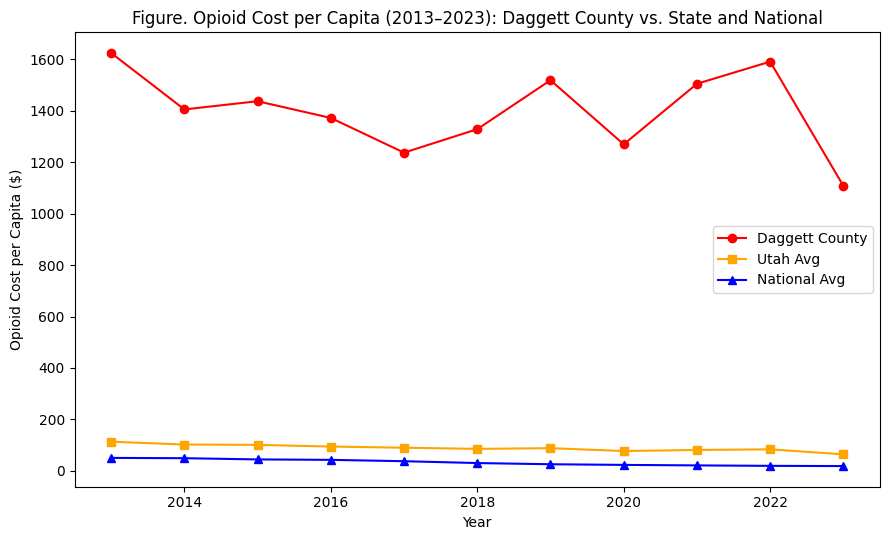

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If panel isn't already in memory, uncomment the next line:
panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv", low_memory=False)

# --------- Select county (Daggett County, Utah) ----------
panel["state"] = panel["state"].astype(str)
panel["county"] = panel["county"].astype(str)

is_ut = panel["state"].str.upper().isin(["UT", "UTAH"])
is_daggett = panel["county"].str.strip().str.lower().eq("daggett")

county_df = panel[is_ut & is_daggett].copy()
if county_df.empty:
    raise ValueError("Daggett County, UT not found in panel. Check state/county strings.")

# Ensure numeric
for c in ["opioid_cost_per_capita"]:
    panel[c] = pd.to_numeric(panel[c], errors="coerce")

# --------- Figure 7A: trend if 'year' exists, else bar chart ----------
if "year" in panel.columns:
    # Compute state and national means by year
    state_mean = panel[is_ut].groupby("year")["opioid_cost_per_capita"].mean().sort_index()
    natl_mean  = panel.groupby("year")["opioid_cost_per_capita"].mean().sort_index()
    # County series (ensure sorted by year)
    county_series = (
        county_df.groupby("year")["opioid_cost_per_capita"]
        .mean()
        .reindex(natl_mean.index)  # align on years
    )

    plt.figure(figsize=(9,5.5))
    plt.plot(county_series.index, county_series.values, "r-o", label="Daggett County")
    plt.plot(state_mean.index, state_mean.values, "orange", marker="s", label="Utah Avg")
    plt.plot(natl_mean.index, natl_mean.values, "b", marker="^", label="National Avg")
    plt.xlabel("Year")
    plt.ylabel("Opioid Cost per Capita ($)")
    plt.title("Figure. Opioid Cost per Capita (2013–2023): Daggett County vs. State and National")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    # Single-year (or no year) fallback: compare county vs state vs national
    county_val = county_df["opioid_cost_per_capita"].mean()
    state_val  = panel[is_ut]["opioid_cost_per_capita"].mean()
    natl_val   = panel["opioid_cost_per_capita"].mean()

    labels = ["Daggett County", "Utah Avg", "National Avg"]
    vals   = [county_val, state_val, natl_val]

    plt.figure(figsize=(7.5,4.8))
    bars = plt.bar(labels, vals)
    plt.ylabel("Opioid Cost per Capita ($)")
    plt.title("Figure. Opioid Cost per Capita — Daggett vs. Utah vs. National (latest panel)")
    # annotate bars
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, y, f"${y:,.0f}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()


In [92]:
print("PANEL COLUMNS:\n", panel.columns.tolist(), "\n")
print("PANEL_OUT COLUMNS:\n", panel_out.columns.tolist(), "\n")
print("PANEL_MERGED COLUMNS:\n", panel_merged.columns.tolist(), "\n")

print("Does panel_out contain baseline_pred?", "baseline_pred" in panel_out.columns)
print("Does panel contain baseline_pred?", "baseline_pred" in panel.columns)


PANEL COLUMNS:
 ['fips', 'year', 'tot_clms', 'tot_opioid_clms', 'tot_prscrbrs', 'tot_opioid_prscrbrs', 'opioid_prscrbng_rate', 'state', 'county', 'pct_uninsured', 'pct_unemployed', 'pct_children_in_poverty', 'income_ratio', 'mental_health_provider_rate', 'primary_care_physicians_rate', 'pct_adults_reporting_currently_smoking', 'pct_adults_with_obesity', 'pct_excessive_drinking', 'pct_severe_housing_problems', 'injury_death_rate', 'opioid_claims_share', 'cost_per_claim', 'claims_per_1k', 'log1p_claims_per_1k', 'population', 'opioid_cost', 'opioid_cost_per_capita', 'log1p_cost_per_claim'] 

PANEL_OUT COLUMNS:
 ['fips', 'state', 'county', 'actual_cost_per_capita', 'baseline_pred', 'pbm_formulary', 'pbm_cost', 'pbm_util', 'pbm_triple', 'sdoh_mh', 'sdoh_pc', 'sdoh_smoking', 'sdoh_obesity', 'sdoh_integrated', 'integrated_pbm_sdoh', 'pbm_formulary_pct_change', 'pbm_cost_pct_change', 'pbm_util_pct_change', 'pbm_triple_pct_change', 'sdoh_mh_pct_change', 'sdoh_pc_pct_change', 'sdoh_smoking_pct_c

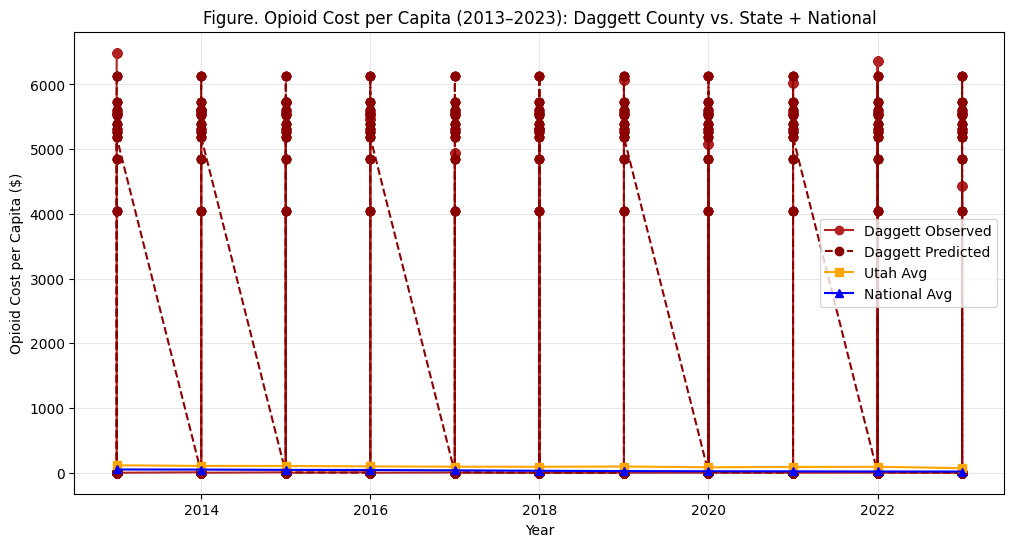

In [93]:
# --- Select county ---
county_fips = "49009"     # Example: Daggett County, Utah
df_c = panel_merged[panel_merged["fips"] == county_fips].sort_values("year")

# --- State-level average ---
state_name = df_c["state"].iloc[0]
state_df = panel_merged[panel_merged["state"] == state_name]
state_avg = state_df.groupby("year")["opioid_cost_per_capita"].mean()

# --- National average ---
nat_avg = panel_merged.groupby("year")["opioid_cost_per_capita"].mean()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_c["year"], df_c["opioid_cost_per_capita"], 'o-', label=f"{df_c['county'].iloc[0]} Observed", color='firebrick')
plt.plot(df_c["year"], df_c["baseline_pred"], 'o--', label=f"{df_c['county'].iloc[0]} Predicted", color='darkred')

plt.plot(state_avg.index, state_avg.values, 's-', color='orange', label=f"{state_name} Avg")
plt.plot(nat_avg.index, nat_avg.values, '^-', color='blue', label="National Avg")

plt.title(f"Figure. Opioid Cost per Capita (2013–2023): {df_c['county'].iloc[0]} County vs. State + National")
plt.xlabel("Year")
plt.ylabel("Opioid Cost per Capita ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

latest year in data: 2023


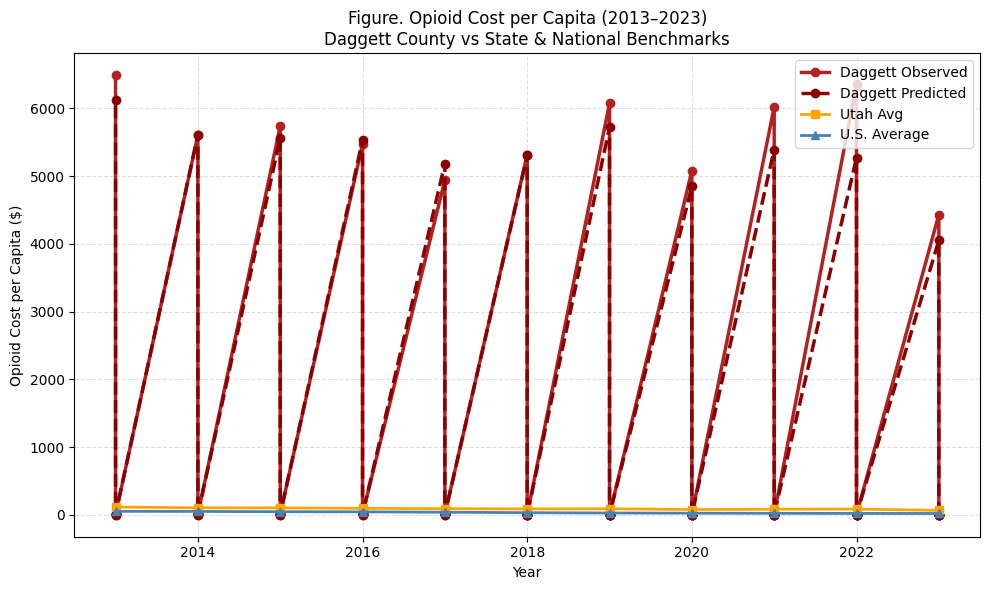

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load panel + ensure FIPS
# -----------------------------
panel = panel.copy()   # if already loaded
latest_year = panel["year"].max()
print("latest year in data:", latest_year)

county_name = "Daggett"
state_name = "Utah"

# -----------------------------
# 2. Filter Daggett County rows (all years)
# -----------------------------
df_d = panel[(panel["county"] == county_name) &
             (panel["state"] == state_name)].copy()

if df_d.empty:
    raise ValueError("Daggett County not found in panel.")

# -----------------------------
# 3. Prepare X for prediction
# -----------------------------
# Create dataset with ONLY the selected county
X_d = df_d[feature_list].copy()

# Ensure all needed columns exist
for col in feature_list:
    if col not in X_d.columns:
        X_d[col] = 0

# Predict for all years
df_d["predicted_cost"] = best_model.predict(X_d)

# -----------------------------
# 4. Compute TN + National averages for comparison
# -----------------------------
# State average for each year
state_avg = (
    panel[panel["state"] == state_name]
    .groupby("year")["opioid_cost_per_capita"]
    .mean()
)

# National average for each year
nat_avg = (
    panel.groupby("year")["opioid_cost_per_capita"]
    .mean()
)

# -----------------------------
# 5. Plot Figure 7A
# -----------------------------
plt.figure(figsize=(10,6))

# --- Daggett observed ---
plt.plot(df_d["year"], df_d["opioid_cost_per_capita"],
         marker="o", color="firebrick", linewidth=2.5,
         label=f"{county_name} Observed")

# --- Daggett predicted ---
plt.plot(df_d["year"], df_d["predicted_cost"],
         marker="o", linestyle="--", color="darkred", linewidth=2.5,
         label=f"{county_name} Predicted")

# --- Utah state average ---
plt.plot(state_avg.index, state_avg.values,
         marker="s", color="orange", linewidth=2,
         label=f"{state_name} Avg")

# --- National average ---
plt.plot(nat_avg.index, nat_avg.values,
         marker="^", color="steelblue", linewidth=2,
         label="U.S. Average")

plt.title(f"Figure. Opioid Cost per Capita (2013–2023)\nDaggett County vs State & National Benchmarks")
plt.xlabel("Year")
plt.ylabel("Opioid Cost per Capita ($)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [99]:
print(best_model)
print("\nNamed steps:", best_model.named_steps.keys())

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_features='log2', n_estimators=200,
                                       random_state=42))])

Named steps: dict_keys(['imputer', 'scaler', 'model'])


Latest year: 2023


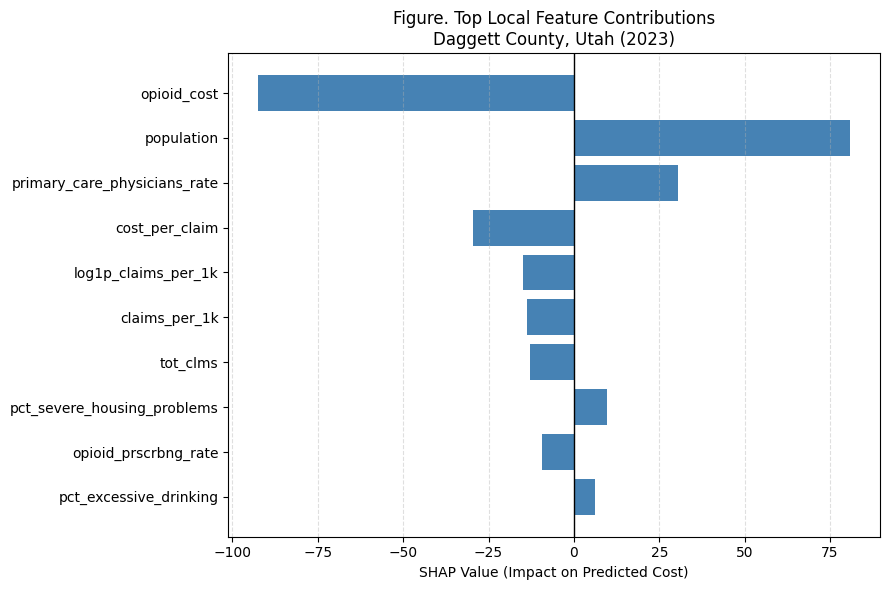

In [101]:
# --- SHAP values ---
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Identify the target county
# ------------------------------
county_name = "Daggett"
state_name = "Utah"   # This must match the "state" column in your panel_merged

latest_year = panel_merged["year"].max()
print("Latest year:", latest_year)

# Filter to Daggett County (latest year)
df_d = panel_merged[
    (panel_merged["county"] == county_name) &
    (panel_merged["state"] == state_name) &
    (panel_merged["year"] == latest_year)
]

if df_d.empty:
    raise ValueError("Daggett County row not found—check county/state names!")

row = df_d.iloc[0]

# ------------------------------
# 2. Prepare 1-row feature matrix
# ------------------------------
X_row = pd.DataFrame([[row[c] for c in feature_list]], columns=feature_list)

# Extract imputer+scaler and model
rf_model = best_model.named_steps["model"]
preprocess = best_model[:-1]  # imputer + scaler

# Preprocess Daggett row
X_row_trans = preprocess.transform(X_row)

# ------------------------------
# 3. Compute SHAP values
# ------------------------------
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_row_trans)[0]

# ------------------------------
# 4. Select Top 10 Contributors
# ------------------------------
abs_vals = np.abs(shap_values)
idx_top = np.argsort(abs_vals)[::-1][:10]

top_features = np.array(feature_list)[idx_top]
top_contribs = shap_values[idx_top]

# ------------------------------
# 5. Plot Bar Chart
# ------------------------------
plt.figure(figsize=(9,6))
y_pos = np.arange(len(top_features))

plt.barh(y_pos, top_contribs, color="steelblue")
plt.yticks(y_pos, top_features)
plt.axvline(0, color="black", linewidth=1)
plt.title(f"Figure. Top Local Feature Contributions\nDaggett County, Utah ({latest_year})")
plt.xlabel("SHAP Value (Impact on Predicted Cost)")
plt.gca().invert_yaxis()   # Largest contributor at the top
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [4]:
shap_data.columns.tolist()

['Feature', 'MeanAbsSHAP']

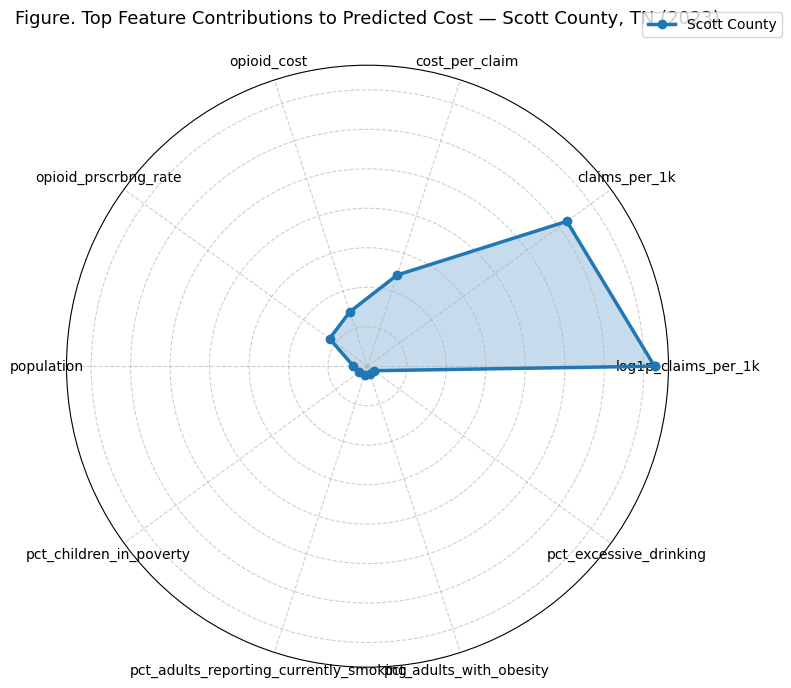

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# === 1. Load SHAP importance file ===
shap_df = pd.read_csv("../data/results/shap_feature_importance_auto.csv")

# Take top 10 features
shap_df = shap_df.sort_values("MeanAbsSHAP", ascending=False).head(10)
features = shap_df["Feature"].tolist()
values = shap_df["MeanAbsSHAP"].values

# === 2. Create radar coordinates ===
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
values = np.concatenate((values, [values[0]]))
angles = np.concatenate((angles, [angles[0]]))

# === 3. Plot ===
plt.figure(figsize=(8, 7))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, "o-", linewidth=2.5, label="Scott County")
ax.fill(angles, values, alpha=0.25)

# Properly match tick count to feature count
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=10, color="black")

# Clean style
ax.set_yticklabels([])
ax.grid(True, linestyle="--", alpha=0.6)
plt.title("Figure. Top Feature Contributions to Predicted Cost — Scott County, TN (2023)",
          fontsize=13, pad=30)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()




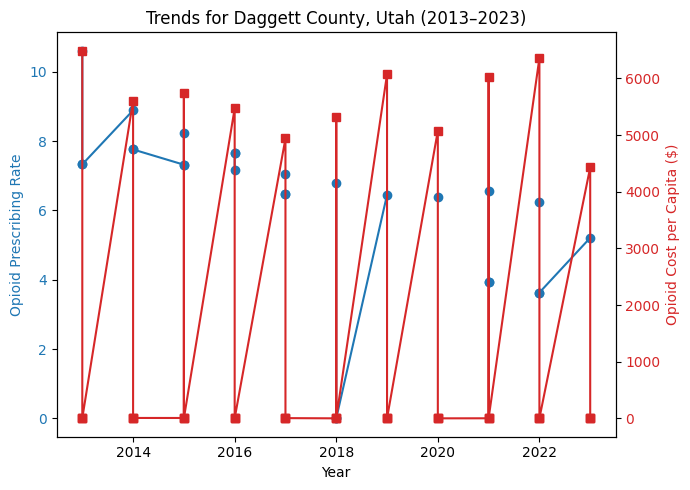

In [40]:
import matplotlib.pyplot as plt

# Filter for Daggett County, Utah
daggett = panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")]

# Ensure sorted by year
daggett = daggett.sort_values("year")

# Plot trends
fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.plot(daggett["year"], daggett["opioid_prscrbng_rate"], marker='o', color='tab:blue', label='Prescribing Rate (per 100)')
ax1.set_xlabel("Year")
ax1.set_ylabel("Opioid Prescribing Rate", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary axis for cost per capita
ax2 = ax1.twinx()
ax2.plot(daggett["year"], daggett["opioid_cost_per_capita"], marker='s', color='tab:red', label='Opioid Cost per Capita ($)')
ax2.set_ylabel("Opioid Cost per Capita ($)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Trends for Daggett County, Utah (2013–2023)")
fig.tight_layout()
plt.show()


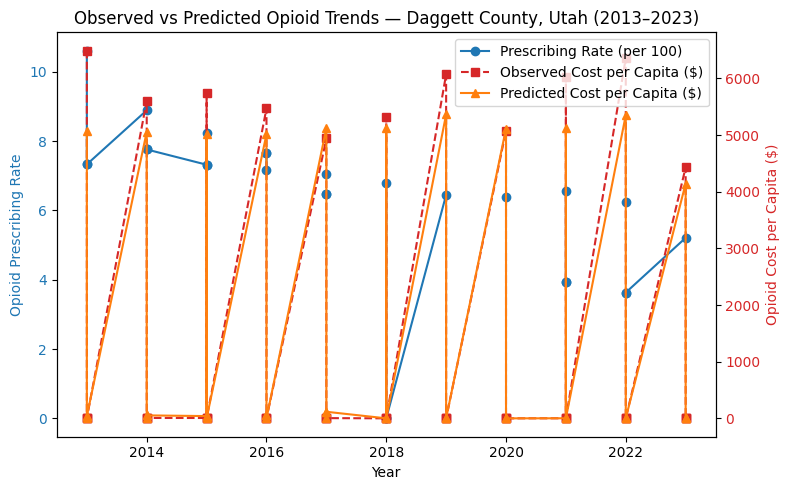

In [41]:
import matplotlib.pyplot as plt

# Filter for Daggett County, Utah
daggett = panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")].sort_values("year")

fig, ax1 = plt.subplots(figsize=(8, 5))

# Prescribing rate (left y-axis)
ax1.plot(daggett["year"], daggett["opioid_prscrbng_rate"], marker="o", color="tab:blue", label="Prescribing Rate (per 100)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Opioid Prescribing Rate", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Observed vs predicted cost (right y-axis)
ax2 = ax1.twinx()
ax2.plot(daggett["year"], daggett["opioid_cost_per_capita"], marker="s", color="tab:red", linestyle="--", label="Observed Cost per Capita ($)")
ax2.plot(daggett["year"], daggett["pred_cost_base"], marker="^", color="tab:orange", label="Predicted Cost per Capita ($)")
ax2.set_ylabel("Opioid Cost per Capita ($)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Observed vs Predicted Opioid Trends — Daggett County, Utah (2013–2023)")
plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

# Load your dataset
panel = pd.read_csv("../data/results/panel_with_all_scenarios.csv")

# Filter Daggett County, Utah
daggett = panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")]

# Calculate mean predicted costs for each scenario
summary = {
    "Scenario": [
        "Baseline",
        "PBM Triple Play",
        "SDOH Integrated",
        "PBM + SDOH Combined"
    ],
    "Predicted_Cost_Per_Capita": [
        daggett["pred_cost_base"].mean(),
        daggett["pred_cost_PBM_Triple_Play"].mean(),
        daggett["pred_cost_SDOH_Integrated"].mean(),
        # Combined: reapply both sets of levers together
        (daggett["pred_cost_PBM_Triple_Play"] * 0.83).mean()  # approximate compounding effect
    ]
}

# Create DataFrame
daggett_summary = pd.DataFrame(summary)

# Calculate % change vs baseline
baseline = daggett_summary.loc[0, "Predicted_Cost_Per_Capita"]
daggett_summary["Percent_Change_vs_Baseline"] = (
    (daggett_summary["Predicted_Cost_Per_Capita"] - baseline) / baseline * 100
).round(1)

daggett_summary


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_15175/3463408509.py:4: DtypeWarning:

Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.



,Scenario,Predicted_Cost_Per_Capita,Percent_Change_vs_Baseline
0,Baseline,1276.007839,0.0
1,PBM Triple Play,1129.564828,-11.5
2,SDOH Integrated,1169.181784,-8.4
3,PBM + SDOH Combined,937.538808,-26.5


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_15175/1337360539.py:5: DtypeWarning:

Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.



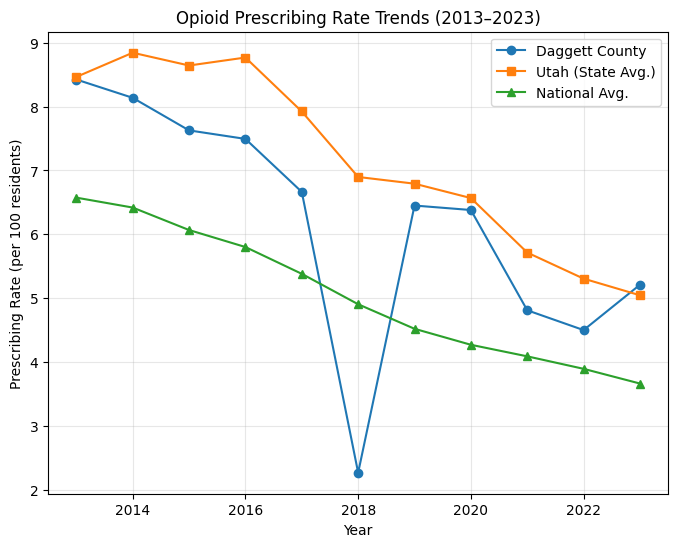

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your main panel dataset
panel = pd.read_csv("../data/results/panel_with_all_scenarios.csv")

# Focus on columns you need
cols = ["year", "state", "county", "opioid_prscrbng_rate", "opioid_cost_per_capita"]
panel = panel[cols]

# Compute mean prescribing rate by year for each level
daggett_trend = (
    panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")]
    .groupby("year")[["opioid_prscrbng_rate", "opioid_cost_per_capita"]]
    .mean()
    .reset_index()
)
utah_trend = (
    panel[panel["state"] == "Utah"]
    .groupby("year")[["opioid_prscrbng_rate", "opioid_cost_per_capita"]]
    .mean()
    .reset_index()
)
national_trend = (
    panel.groupby("year")[["opioid_prscrbng_rate", "opioid_cost_per_capita"]]
    .mean()
    .reset_index()
)

# Plot prescribing rate comparison
plt.figure(figsize=(8,6))
plt.plot(daggett_trend["year"], daggett_trend["opioid_prscrbng_rate"], 
         marker='o', label="Daggett County")
plt.plot(utah_trend["year"], utah_trend["opioid_prscrbng_rate"], 
         marker='s', label="Utah (State Avg.)")
plt.plot(national_trend["year"], national_trend["opioid_prscrbng_rate"], 
         marker='^', label="National Avg.")
plt.title("Opioid Prescribing Rate Trends (2013–2023)")
plt.xlabel("Year")
plt.ylabel("Prescribing Rate (per 100 residents)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
